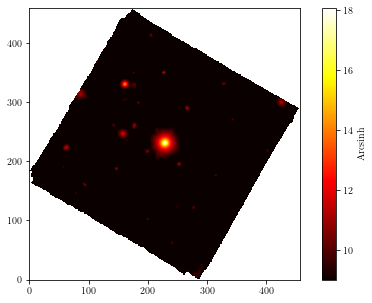

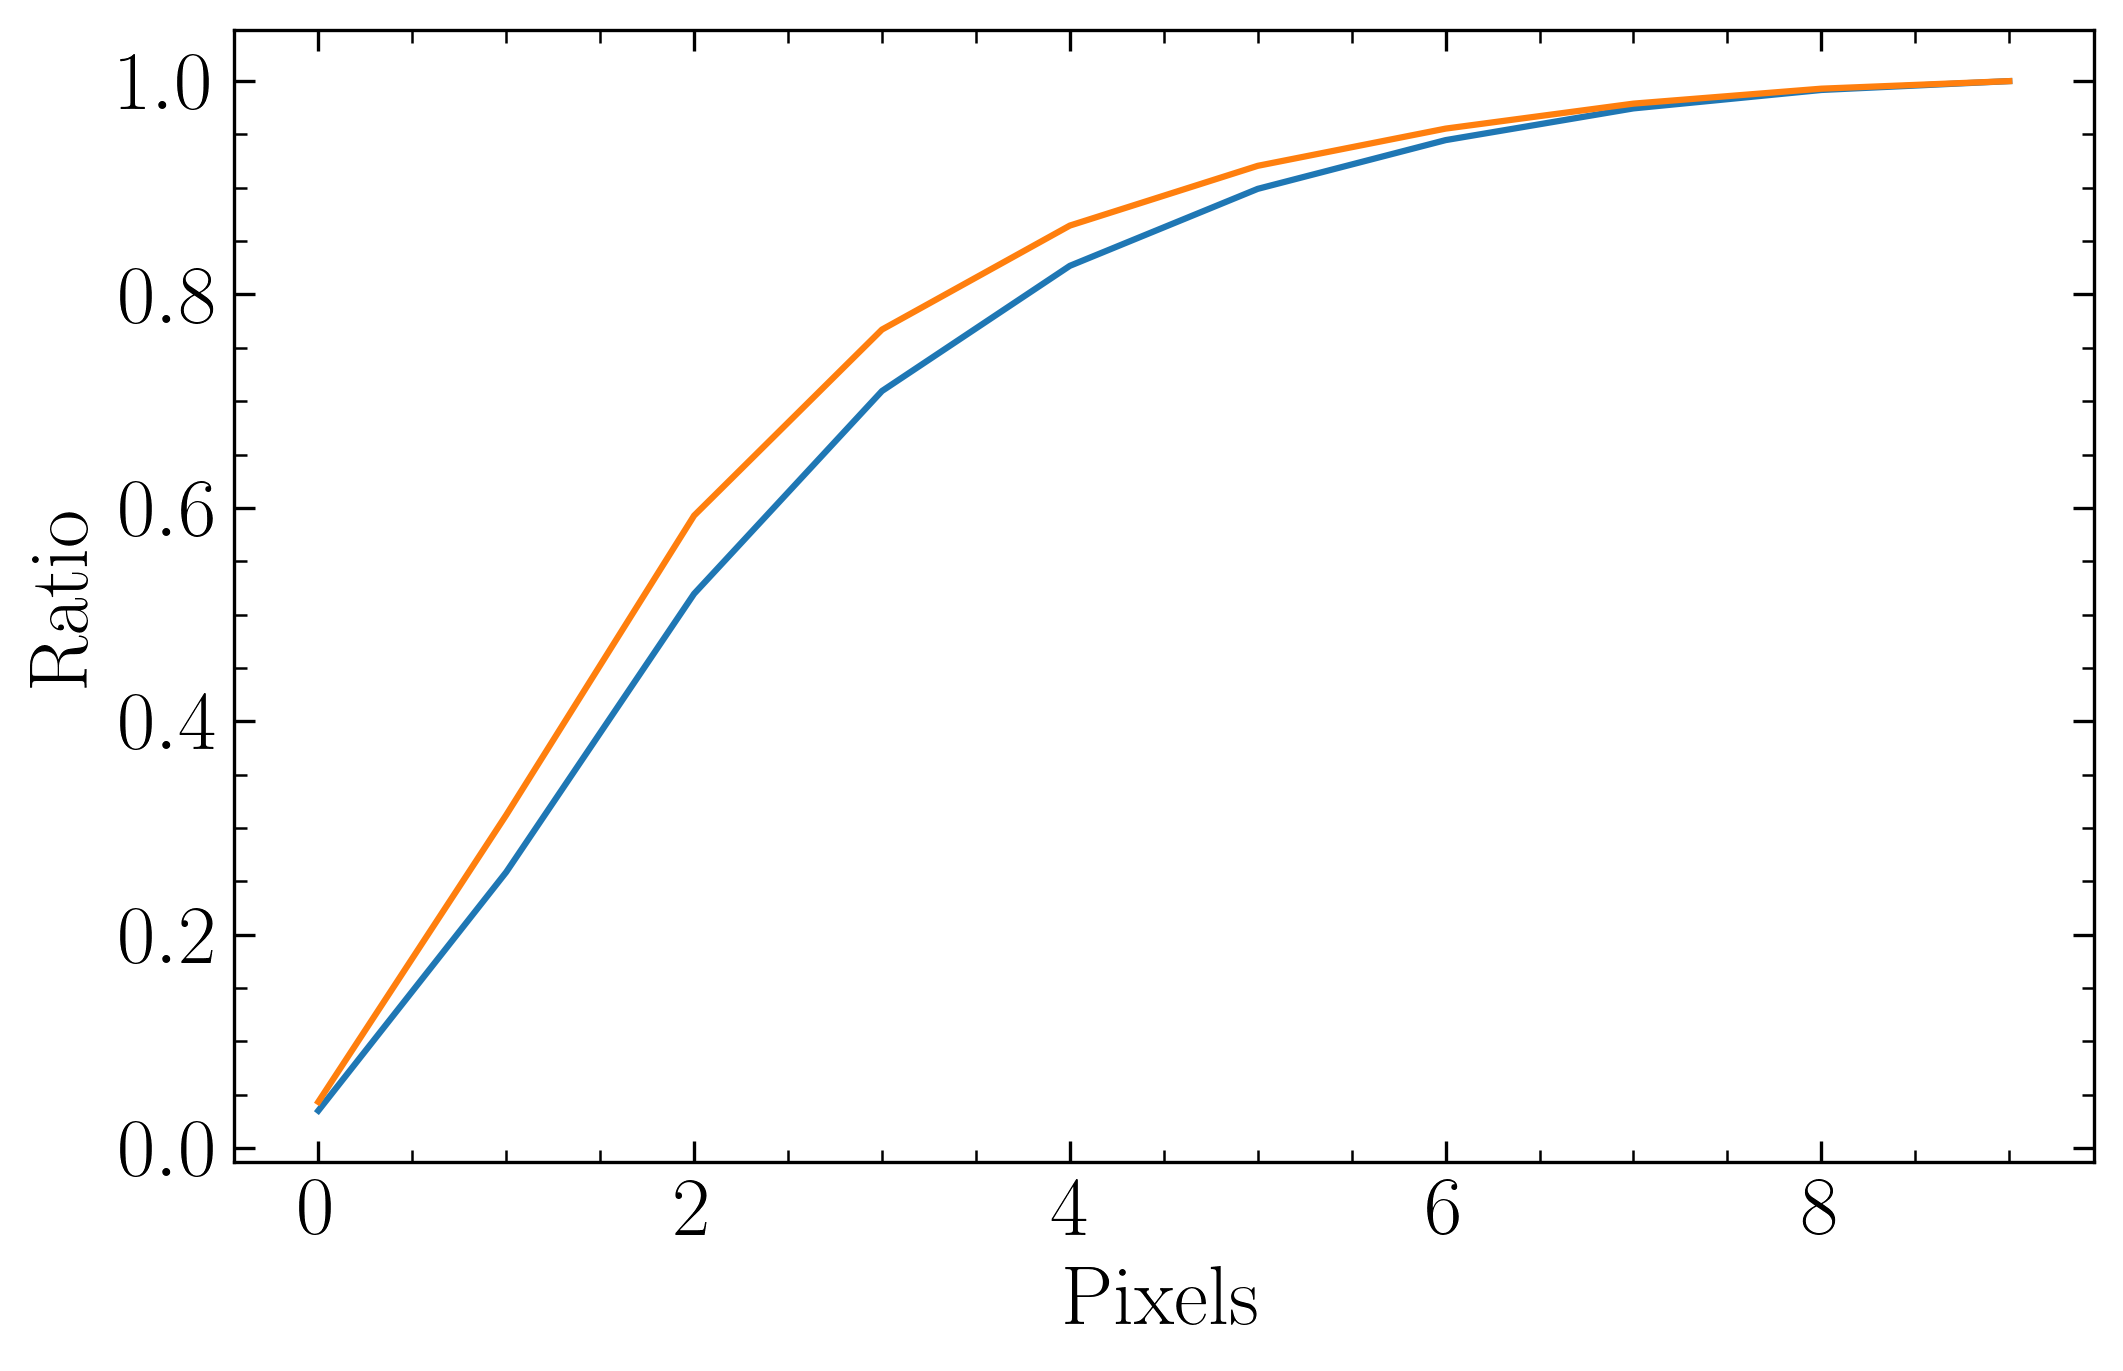

In [2]:
import lmfit
import numpy as np
import matplotlib.pyplot as plt
import os
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
from matplotlib import rc
from PyAstronomy import pyasl
rc('font', **{'family':'serif', 'serif':['Times New Roman']})
rc('text', usetex=True)

path = os.path.join(os.sep, 'Users', 'lzq', 'Desktop', 'redshifting', 'ESO_DEEP_offset_zapped.fits')
cube = Cube(path)

# Calculate the white image
image_white = cube.sum(axis=0)

plt.figure(figsize=(8, 5), dpi=300)
plt.imshow(np.arcsinh(image_white.data), origin='lower', vmin=9, cmap='hot')
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{Arcsinh}$')
# plt.axis('off')
# plt.savefig('/Users/lzq/Desktop/qso_ism/qso_image.png', bbox_inches='tight')

p, q = image_white.peak()['p'], image_white.peak()['q']

# EE Curve
EE_ape = cube.subcube_circle_aperture((p, q), 10, unit_center=None, unit_radius=None)
source_100 = EE_ape[350, :, :]  # change to wavelength instead of index
radius_100, ee_100 = source_100.eer_curve(unit_center=None, unit_radius=None)
source_200 = EE_ape[3000, :, :]
radius_200, ee_200 = source_200.eer_curve(unit_center=None, unit_radius=None)

# Make the EE plot
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(radius_100, ee_100)
plt.plot(radius_200, ee_200)
plt.xlabel(r'$\mathrm{Pixels}$', size=20)
plt.ylabel(r'$\mathrm{Ratio}$', size=20)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='in', top='on', bottom='on', left='on', right='on',
                labelsize=20, size=5)
plt.tick_params(axis='both', which='minor', direction='in', top='on', bottom='on', left='on', right='on',
                size=3)
# plt.savefig('/Users/lzq/Desktop/qso_ism/ee_curve',  bbox_inches='tight')

In [159]:

# Spectrum
cube_ape = cube.aperture((p, q), 2, unit_center=None, unit_radius=None, is_sum=True)

wave_vac = pyasl.airtovac2(cube_ape.wave.coord())  # convert air wavelength to vacuum 2. measure the redshift (OII doublet emission line) 3. luminosity and the line width of Hbeta
flux = cube_ape.data * 1e-3
flux_err = np.sqrt(cube_ape.var) * 1e-3

print((np.sqrt(cube_ape.var)/cube_ape.data).max())

# Fitting the redshift
wave_OII3727_vac = 3727.092
wave_OII3729_vac = 3729.875
c_kms = 2.998e5

OII_region = np.where((wave_vac > 6050) * (wave_vac < 6100))
wave_OII_vac = wave_vac[OII_region]
flux_OII = flux[OII_region]

# Define a function with the MUSE resolution
def getFWHM_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04)

# Define a function with the MUSE resolution
def getSigma_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04) / 2.355

# Define the model fit function
def model(wave_vac, z, sigma_kms, fluxOII, rOII3729_3727, a, b):
    wave_OII3727_obs = wave_OII3727_vac * (1 + z)
    wave_OII3729_obs = wave_OII3729_vac * (1 + z)

#     sigma_OII3727_A = np.sqrt((sigma_kms / c_kms * wave_OII3727_obs) ** 2 + (getSigma_MUSE(wave_OII3727_obs)) ** 2)
#     sigma_OII3729_A = np.sqrt((sigma_kms / c_kms * wave_OII3729_obs) ** 2 + (getSigma_MUSE(wave_OII3729_obs)) ** 2)

    sigma_OII3727_A = sigma_kms / c_kms * wave_OII3727_obs
    sigma_OII3729_A = sigma_kms / c_kms * wave_OII3729_obs
    
    fluxOII3727 = fluxOII / (1 + rOII3729_3727)
    fluxOII3729 = fluxOII / (1 + 1.0 / rOII3729_3727)

    peakOII3727 = fluxOII3727 / np.sqrt(2 * sigma_OII3727_A ** 2 * np.pi)
    peakOII3729 = fluxOII3729 / np.sqrt(2 * sigma_OII3729_A ** 2 * np.pi)

    OII3727_gaussian = peakOII3727 * np.exp(-(wave_vac - wave_OII3727_obs) ** 2 / 2 / sigma_OII3727_A ** 2)
    OII3729_gaussian = peakOII3729 * np.exp(-(wave_vac - wave_OII3729_obs) ** 2 / 2 / sigma_OII3729_A ** 2)

    return OII3727_gaussian + OII3729_gaussian + a * wave_vac + b


redshift_guess = 0.63
sigma_kms_guess = 150.0
flux_OII_guess = 42
rOII3729_3727_guess = 100

parameters = lmfit.Parameters()
parameters.add_many(('sigma_kms', sigma_kms_guess, True, 10.0, 500.0, None),
                    ('z', redshift_guess, True, None, None, None),
                    ('fluxOII', flux_OII_guess, True, None, None, None),
                    ('rOII3729_3727', rOII3729_3727_guess, True, 0, 3, None),
                    ('a', 0.0, True, None, None, None),
                    ('b', 100, True, None, None, None))
spec_model = lmfit.Model(model, missing='drop')

result = spec_model.fit(flux_OII, wave_vac=wave_OII_vac, params=parameters)

print('Success = {}'.format(result.success))
print(result.fit_report())


[INFO] 16 spaxels used


0.010530100577025267
Success = True
[[Model]]
    Model(model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 40
    # variables        = 6
    chi-square         = 6.51919313
    reduced chi-square = 0.19174097
    Akaike info crit   = -60.5651535
    Bayesian info crit = -50.4318768
[[Variables]]
    sigma_kms:      124.969665 +/- 38.9496011 (31.17%) (init = 150)
    z:              0.62833850 +/- 2.5967e-04 (0.04%) (init = 0.63)
    fluxOII:        17.0034588 +/- 2.37765817 (13.98%) (init = 42)
    rOII3729_3727:  2.99999959 +/- 3.58427278 (119.48%) (init = 3)
    a:             -0.01009948 +/- 0.00487758 (48.30%) (init = 0)
    b:              117.041232 +/- 29.6331869 (25.32%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)                     = -1.000
    C(z, rOII3729_3727)         = -0.895
    C(sigma_kms, rOII3729_3727) =  0.767
    C(sigma_kms, z)             = -0.689
    C(sigma_kms, fl

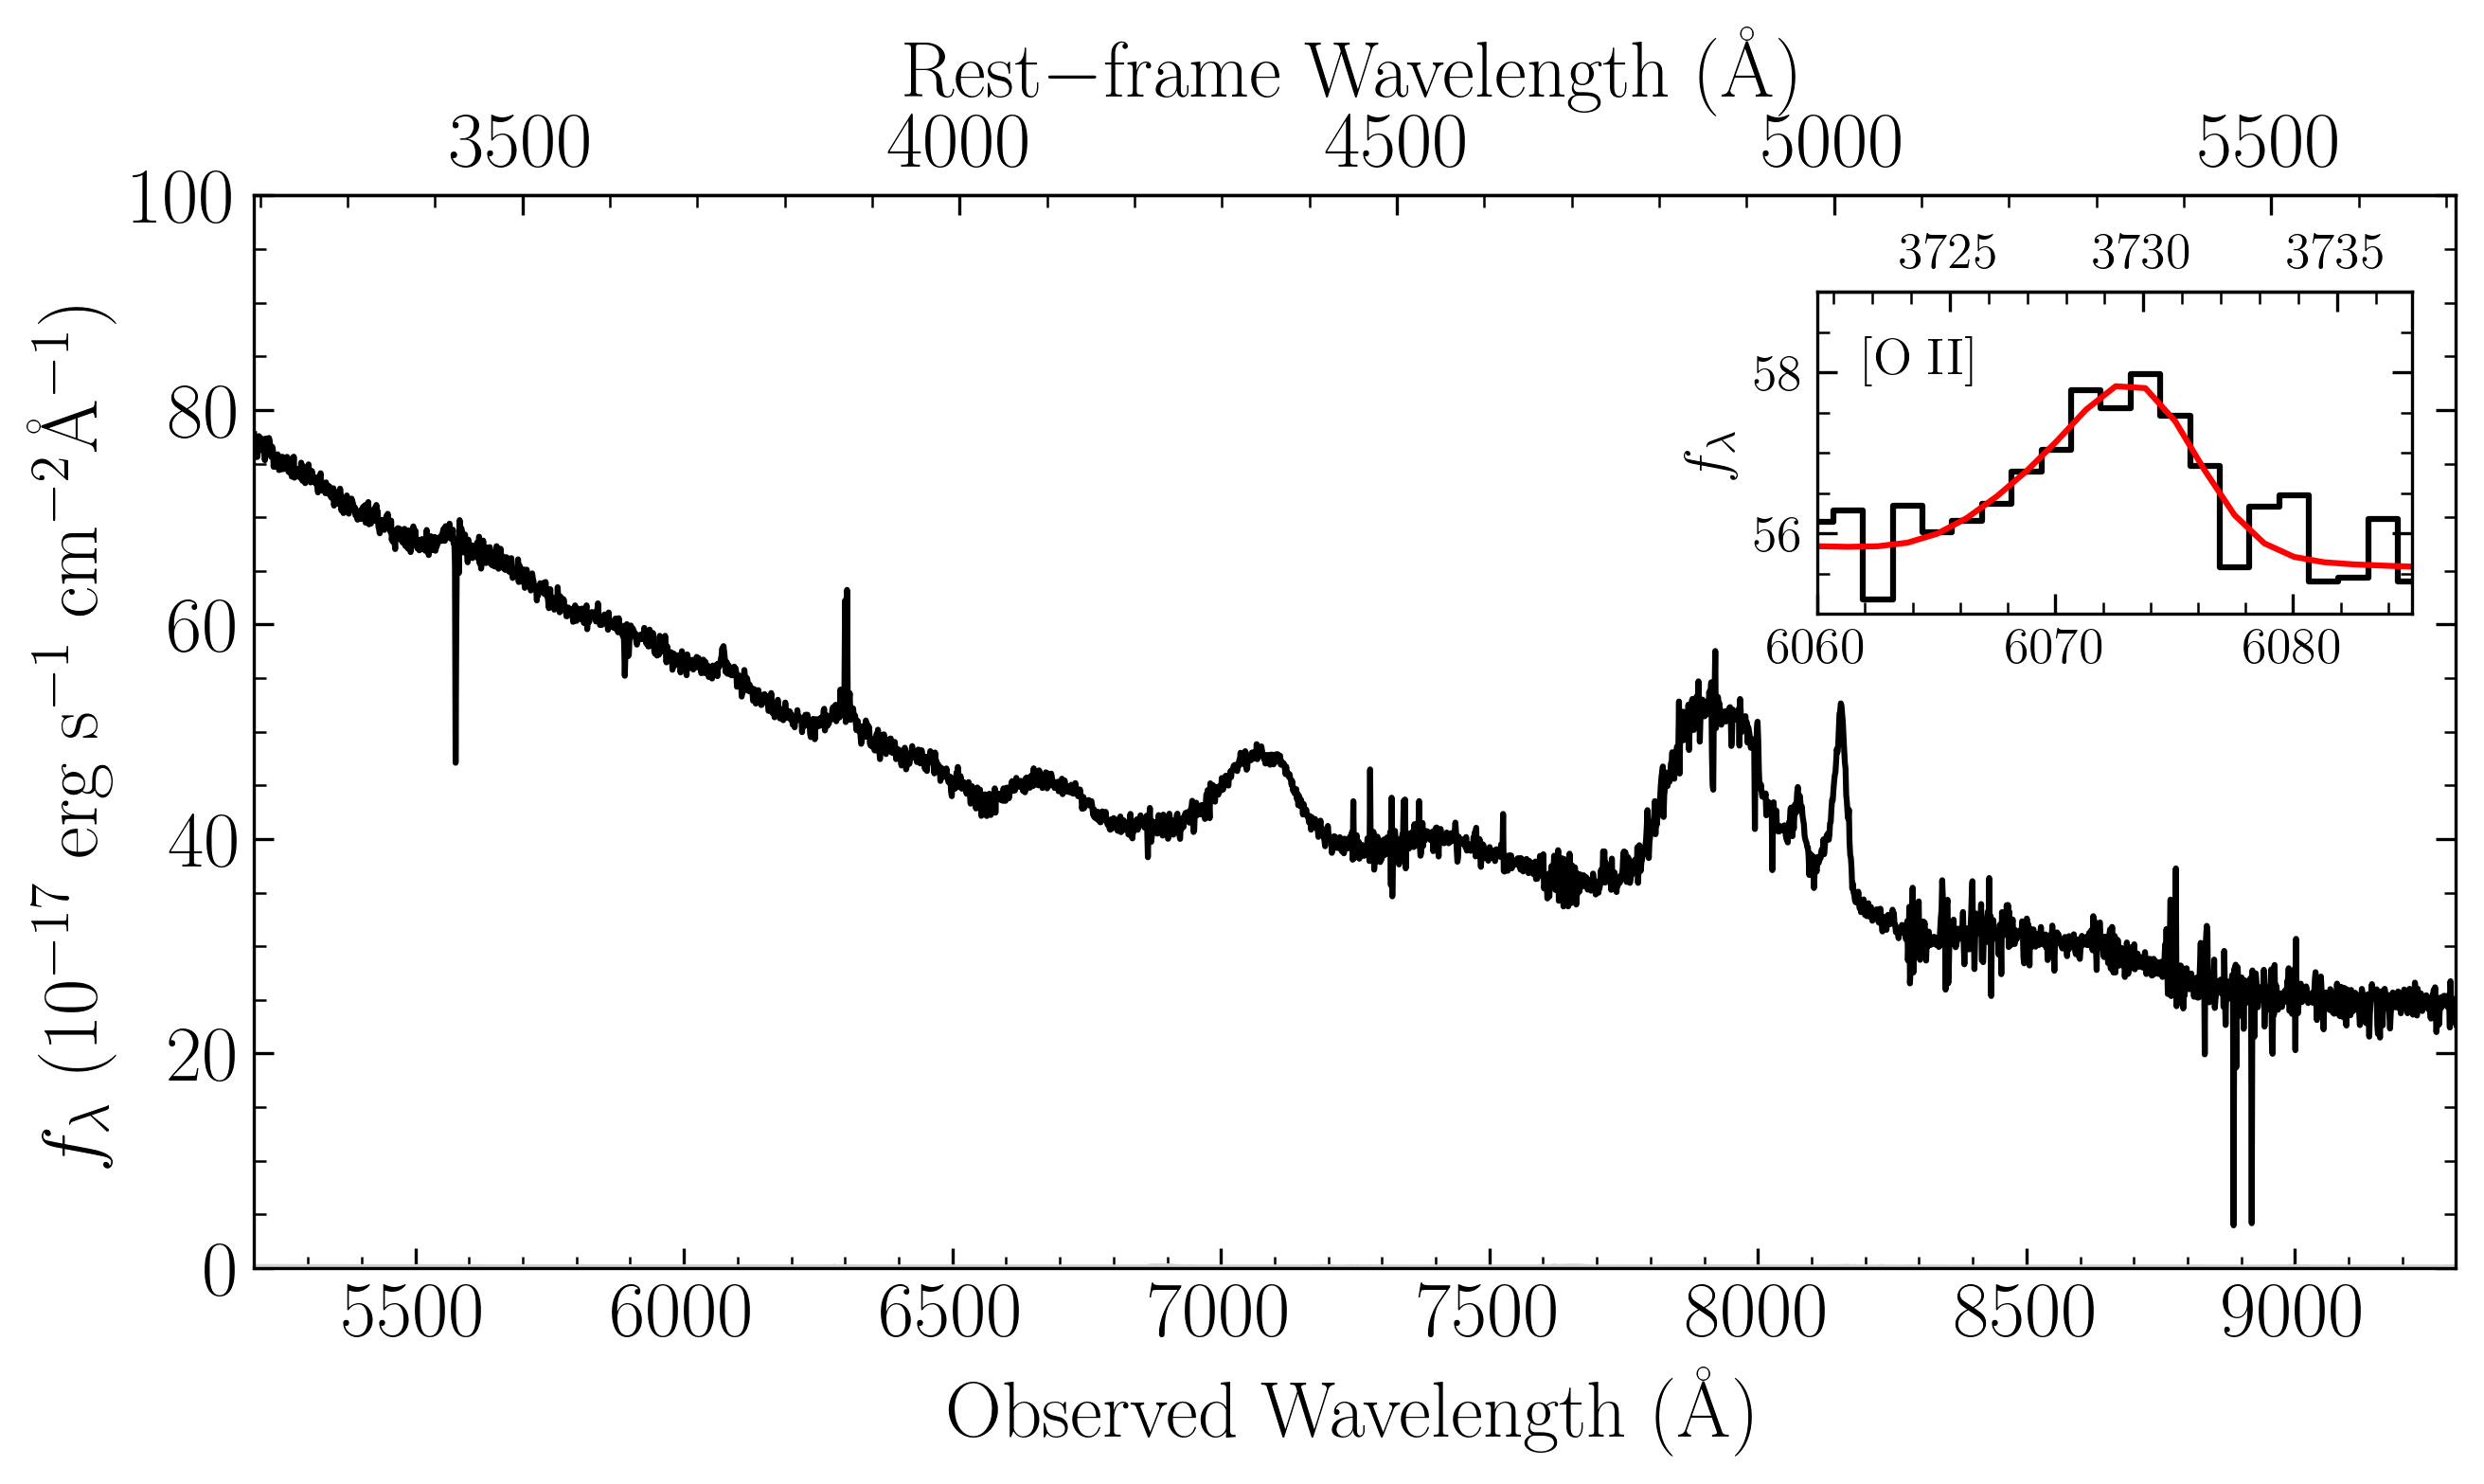

In [160]:
z = result.best_values['z']

# 
# fig, ax = plt.subplots(1)
# ax.plot(wave_OII_vac, flux_OII, color='black', drawstyle='steps-mid')
# #ax.plot(spec['wave'], spec['error'], color='blue', drawstyle='steps-mid')
# ax.plot(wave_OII_vac, result.best_fit, color='red')
# ax.minorticks_on()
# fig.tight_layout()

def rest2obs(x):
    return x * (1 + z)

def obs2rest(x):
    return x / (1 + z)


# Plot the Spectrum
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
ax.plot(wave_vac, flux, color='k')
ax.plot(wave_vac, flux_err, color='lightgrey')
ax.set_xlim(5200, 9300)
ax.set_ylim(0, 100)
ax.set_xlabel(r'$\mathrm{Observed \; Wavelength \; (\AA)}$', size=20)
ax.set_ylabel(r'${f}_{\lambda} \; (10^{-17} \; \mathrm{erg \; s^{-1} \; cm^{-2} \AA^{-1}})$', size=20)

secax = ax.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secax.minorticks_on()
secax.set_xlabel(r'$\mathrm{Rest \mathrm{-} frame \; Wavelength \; (\AA)}$', size=20)
secax.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=20)
secax.tick_params(axis='x', which='minor', direction='in', top='on', size=3)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on',
                labelsize=20, size=5)
ax.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on',
                size=3)

axins = ax.inset_axes([0.71, 0.61, 0.27, 0.3])
axins.plot(wave_OII_vac, flux_OII, color='black', drawstyle='steps-mid')
axins.plot(wave_OII_vac, result.best_fit, color='red')
axins.set_xlim(6060, 6085)
axins.set_ylim(55, 59)
axins.set_ylabel(r'${f}_{\lambda}$', size=15)
axins.text(6062, 58, r'$\mathrm{[O\;II]}$', size=13)
axins.minorticks_on()
axins.tick_params(axis='both', which='major', direction='in', bottom='on', left='on', right='on',
                  labelsize=13, size=5)
axins.tick_params(axis='both', which='minor', direction='in', bottom='on', left='on', right='on',
                  size=3)

secaxins = axins.secondary_xaxis('top', functions=(obs2rest, rest2obs))
secaxins.minorticks_on()
secaxins.tick_params(axis='x', which='major', direction='in', top='on', size=5, labelsize=13)
secaxins.tick_params(axis='x', which='minor', direction='in', top='on', size=3)





